In [113]:
import pandas as pd
import numpy as np
import argparse
import itertools
import matplotlib.pyplot as plt

import re
import os
from os import path
import sys
import time

In [114]:
df_dict = {
    'type': [],
    'qps': [],
    'i' : [],
    'ins': [],
    'cyc': [],
    'refcyc': [],
    'joules': [],
    'tail': [],
}

def resetdict():
    for key in df_dict:
        df_dict[key] = []

def parseLat(s):
    with open(s) as file:
        for line in file:
            #print(line.strip())
            if 'read' in line:
                return float((line.strip().split())[9])

## EbbRT C220G1

In [129]:
qps=0
i=0
type='ebbrt_c220g1'
with open("c220g1/mcd/results.md") as file:
    for line in file:        
        ins=0
        cyc=0
        refcyc=0
        joules=0.0
        if "MQPS" in line.strip():
            qps = int(line.strip().split(' ')[2])
            i = 0
        elif "[STATS ALL]" in line.strip():            
            tmp = line.strip().split(' ')
            #print(tmp)
            ins = int(tmp[2])
            cyc = int(tmp[3])
            refcyc = int(tmp[4])
            joules = float(tmp[5])

            df_dict['type'].append(type)
            df_dict['qps'].append(qps)
            df_dict['i'].append(i)
            df_dict['ins'].append(ins)
            df_dict['cyc'].append(cyc)
            df_dict['refcyc'].append(refcyc)
            df_dict['joules'].append(joules)
            df_dict['tail'].append(parseLat(f"c220g1/mcd/ebbrtbm_qps{qps}_iter{i}.out"))
            i += 1
df = pd.DataFrame(df_dict)
qpss=df['qps'].unique()
dfebbrt = df.groupby(['qps']).mean()
dfebbrt['type'] = type
dfebbrt['ipc'] = dfebbrt['ins']/dfebbrt['refcyc']
dfebbrt=dfebbrt.drop(columns=['i'])
dfebbrt['qps']=qpss
print(dfebbrt)

                  ins           cyc        refcyc       joules      tail  \
qps                                                                        
200000   4.777431e+10  1.154030e+11  1.194927e+11  1605.865000    96.225   
400000   9.507178e+10  2.118485e+11  2.044379e+11  1736.340000    96.125   
600000   1.422908e+11  3.022215e+11  2.843202e+11  1771.232500    96.125   
800000   1.893191e+11  3.853599e+11  3.584828e+11  1860.865000    95.900   
1000000  2.363764e+11  4.638384e+11  4.294849e+11  1947.627500    96.050   
1200000  2.836647e+11  5.395560e+11  4.986063e+11  1975.082500    96.200   
1400000  3.303890e+11  6.078982e+11  5.613737e+11  2077.532500    96.100   
1600000  3.778211e+11  6.791168e+11  6.269814e+11  2152.235000    96.200   
1800000  4.251856e+11  7.451455e+11  6.878753e+11  2200.093333    96.300   
2000000  4.725948e+11  8.104864e+11  7.481646e+11  2253.220000    96.550   
2200000  5.206181e+11  8.726308e+11  8.055277e+11  2329.455000    98.700   
2400000  5.6

/tmp/ipykernel_4451/2934862684.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfebbrt = df.groupby(['qps']).mean()


In [141]:
#plt.scatter(range(200000, 3200000, 200000), dfebbrt['tail'])
#plt.show()

#dfebbrt.plot(x="qps", y=["tail"], kind="scatter")

    #df.plot(x="nmappers", y=ys, kind="bar", legend=False, title=name) 


## Linux C220G1

In [98]:
## Overheads
resetdict()
ins_oh=0
cyc_oh=0
refcyc_oh=0
joules_oh=0.0
with open(f"c220g1/linux_mcd/PerfStat.Overhead.iter0") as file:
    for line in file:      
        #print(line.strip())
        if 'instructions' in line:
            #print(line)
            ins_oh = int((line.strip().split(','))[0])
        elif "ref-cycles" in line:
            refcyc_oh = int((line.strip().split(','))[0])
        elif 'cycles' in line:
            cyc_oh = int((line.strip().split(','))[0])
        elif 'Joules' in line:
            #print(line)
            joules_oh = float((line.strip().split(','))[0])
            
print(ins_oh, cyc_oh, refcyc_oh, joules_oh)
type='linux_c220g1'
iter=1
for mqps in range(200000, 1200000, 200000):
    ins=0
    cyc=0
    refcyc=0
    joules=0.0
    with open(f"c220g1/linux_mcd/PerfStat.linux_mcd_qps{mqps}_iter{iter}") as file:
        for line in file:  
            if 'instructions' in line:
                ins = int((line.strip().split(','))[0]) - ins_oh
            elif "ref-cycles" in line:
                refcyc = int((line.strip().split(','))[0]) - cyc_oh
            elif 'cycles' in line:
                cyc = int((line.strip().split(','))[0]) - refcyc_oh
            elif 'Joules' in line:
                joules = float((line.strip().split(','))[0]) - joules_oh
    tail = parseLat(f"c220g1/linux_mcd/linux_mcd_qps{mqps}_iter{iter}.out")
    df_dict['type'].append(type)
    df_dict['qps'].append(mqps)
    df_dict['i'].append(iter)
    df_dict['ins'].append(ins)
    df_dict['cyc'].append(cyc)
    df_dict['refcyc'].append(refcyc)
    df_dict['joules'].append(joules)
    df_dict['tail'].append(tail)


8429714962 24610077751 28589808096 464.3


In [102]:
dflinux_c220g1 = pd.DataFrame(df_dict)
dflinux_c220g1['ipc'] = dflinux_c220g1['ins']/dflinux_c220g1['refcyc']
dflinux_c220g1=dflinux_c220g1.drop(columns=['i'])
dflinux_c220g1



,type,qps,ins,cyc,refcyc,joules,tail,ipc
0,linux_c220g1,200000,239950945833,481090261201,454792756169,1846.86,114.4,0.527605
1,linux_c220g1,400000,433746590530,897313224376,836033765705,2181.25,119.3,0.518815
2,linux_c220g1,600000,596781352351,1290235432942,1198516205657,2492.15,144.3,0.497933
3,linux_c220g1,800000,730467632684,1603890644599,1488367329785,2671.80,225.7,0.490785
4,linux_c220g1,1000000,831621804805,1837319577301,1703658433985,2803.27,1161.6,0.488139


## Linux C220G5

In [154]:
## Overheads
resetdict()
ins_oh=0
cyc_oh=0
refcyc_oh=0
joules_oh=0.0
with open(f"c220g5/linux_mcd/PerfStat.Overhead.iter0") as file:
    for line in file:      
        #print(line.strip())
        if 'instructions' in line:
            #print(line)
            ins_oh = int((line.strip().split(','))[0])
        elif "ref-cycles" in line:
            refcyc_oh = int((line.strip().split(','))[0])
        elif 'cycles' in line:
            cyc_oh = int((line.strip().split(','))[0])
        elif 'Joules' in line:
            #print(line)
            joules_oh = float((line.strip().split(','))[0])
            
print(ins_oh, cyc_oh, refcyc_oh, joules_oh)
type='linux_c220g5'
iter=1
for mqps in range(200000, 1400000, 200000):
    ins=0
    cyc=0
    refcyc=0
    joules=0.0
    with open(f"c220g5/linux_mcd/PerfStat.linux_mcd_qps{mqps}_iter{iter}") as file:
        for line in file:  
            if 'instructions' in line:
                ins = int((line.strip().split(','))[0]) - ins_oh
            elif "ref-cycles" in line:
                refcyc = int((line.strip().split(','))[0]) - cyc_oh
            elif 'cycles' in line:
                cyc = int((line.strip().split(','))[0]) - refcyc_oh
            elif 'Joules' in line:
                joules = float((line.strip().split(','))[0]) - joules_oh
    tail = parseLat(f"c220g5/linux_mcd/linux_mcd_qps{mqps}_iter{iter}.out")
    df_dict['type'].append(type)
    df_dict['qps'].append(mqps)
    df_dict['i'].append(iter)
    df_dict['ins'].append(ins)
    df_dict['cyc'].append(cyc)
    df_dict['refcyc'].append(refcyc)
    df_dict['joules'].append(joules)
    df_dict['tail'].append(tail)

dflinux_c220g5 = pd.DataFrame(df_dict)
dflinux_c220g5['ipc'] = dflinux_c220g5['ins']/dflinux_c220g5['refcyc']
dflinux_c220g5=dflinux_c220g5.drop(columns=['i'])
dflinux_c220g5



9144157972 16176438755 30796638400 797.65


,type,qps,ins,cyc,refcyc,joules,tail,ipc
0,linux_c220g5,200000,235322243634,445977257326,465411054885,2481.56,111.7,0.505622
1,linux_c220g5,400000,427930383233,870370706915,797614736189,2742.76,113.5,0.536513
2,linux_c220g5,600000,595829383166,1277686737646,1151685499477,3095.41,125.4,0.517354
3,linux_c220g5,800000,740752717227,1658900532495,1487164634853,3298.32,161.6,0.498097
4,linux_c220g5,1000000,850811183082,1977367933608,1767906108349,3444.09,330.7,0.481254
5,linux_c220g5,1200000,926223561158,2234808520636,1994289374029,3557.73,1897.6,0.464438


In [ ]:
## EbbRT sm220u

In [156]:
## Overheads
resetdict()
ins_oh=0
cyc_oh=0
refcyc_oh=0
joules_oh=0.0
with open(f"sm220u/linux_mcd/PerfStat.Overhead.iter0") as file:
    for line in file:      
        #print(line.strip())
        if 'instructions' in line:
            #print(line)
            ins_oh = int((line.strip().split(','))[0])
        elif "ref-cycles" in line:
            refcyc_oh = int((line.strip().split(','))[0])
        elif 'cycles' in line:
            cyc_oh = int((line.strip().split(','))[0])
        elif 'Joules' in line:
            #print(line)
            joules_oh = float((line.strip().split(','))[0])
            
print(ins_oh, cyc_oh, refcyc_oh, joules_oh)
type='linux_sm220u'
iter=1
for mqps in range(200000, 1400000, 200000):
    ins=0
    cyc=0
    refcyc=0
    joules=0.0
    with open(f"sm220u/linux_mcd/PerfStat.linux_mcd_qps{mqps}_iter{iter}") as file:
        for line in file:  
            if 'instructions' in line:
                ins = int((line.strip().split(','))[0]) - ins_oh
            elif "ref-cycles" in line:
                refcyc = int((line.strip().split(','))[0]) - cyc_oh
            elif 'cycles' in line:
                cyc = int((line.strip().split(','))[0]) - refcyc_oh
            elif 'Joules' in line:
                joules = float((line.strip().split(','))[0]) - joules_oh
    tail = parseLat(f"sm220u/linux_mcd/linux_mcd_qps{mqps}_iter{iter}.out")
    df_dict['type'].append(type)
    df_dict['qps'].append(mqps)
    df_dict['i'].append(iter)
    df_dict['ins'].append(ins)
    df_dict['cyc'].append(cyc)
    df_dict['refcyc'].append(refcyc)
    df_dict['joules'].append(joules)
    df_dict['tail'].append(tail)

dflinux_sm220u = pd.DataFrame(df_dict)
dflinux_sm220u['ipc'] = dflinux_sm220u['ins']/dflinux_sm220u['refcyc']
dflinux_sm220u=dflinux_sm220u.drop(columns=['i'])
dflinux_sm220u



12192223905 17919659555 16035843456 2464.44


,type,qps,ins,cyc,refcyc,joules,tail,ipc
0,linux_sm220u,200000,282619379868,458722998262,373668475357,5220.55,127.0,0.756337
1,linux_sm220u,400000,518752437463,862610740206,709275280957,5561.03,147.6,0.731384
2,linux_sm220u,600000,741156856359,1275334742312,1051992647197,5890.93,169.7,0.704527
3,linux_sm220u,800000,946809716321,1658407253098,1369037892541,6192.21,191.7,0.691588
4,linux_sm220u,1000000,1140405706533,2003525285328,1654771955101,6453.28,197.5,0.689162
5,linux_sm220u,1200000,1314220879427,2330962933072,1925785025725,6676.17,218.2,0.682434


In [163]:
def mplot(x, y, ylimt=-1):   
    for df in [dfebbrt, dflinux_c220g1, dflinux_c220g5, dflinux_sm220u]:
        plt.scatter(df[x], df[y], label=df['type'].unique())
    plt.xlabel(x)
    plt.ylabel(y)

    if ylimt != -1:
        plt.ylim(bottom=0, top=ylimt)
    else:
        plt.ylim(bottom=0)
    plt.legend()
    plt.show()

In [167]:
dfebbrt.columns

Index(['ins', 'cyc', 'refcyc', 'joules', 'tail', 'type', 'ipc', 'qps'], dtype='object')

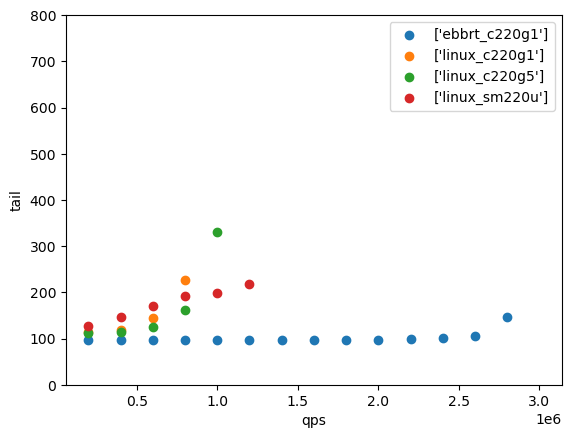

In [164]:
mplot('qps', 'tail', 800)

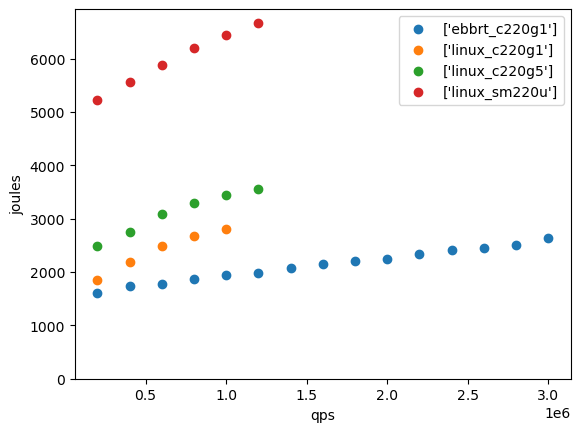

In [165]:
mplot('qps', 'joules')

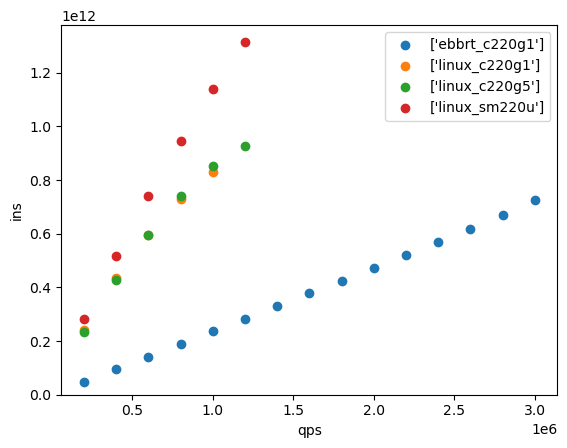

In [166]:
mplot('qps', 'ins')

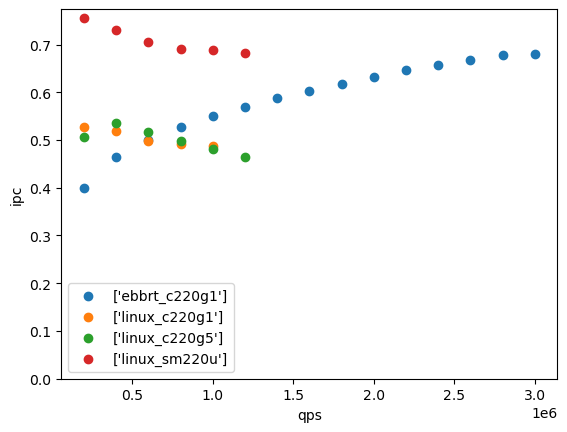

In [168]:
mplot('qps', 'ipc')